In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env VECLIB_MAXIMUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: VECLIB_MAXIMUM_THREADS=1


In [2]:
from wgan.imblearn import GANbalancer

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

from functools import partial
from lift.perc_lift_score import perc_lift_score

In [4]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=4000, n_features=20, weights=[0.95,0.05], 
                          n_informative=20, n_redundant=0, n_clusters_per_class=1)
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
#idx_cont = list(range(20))
#categorical = None

In [5]:
no_cont = 15
ct = ColumnTransformer([
    ("scaler", MinMaxScaler(), slice(0,no_cont)),
    ("discretizer", KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile"),
     slice(no_cont,20))
], remainder="drop")
X = ct.fit_transform(X)

idx_cat = list(range(no_cont,20))
idx_cont = list(range(no_cont))
categorical = [(i, 5, 3) for i in range(no_cont,20)]

In [6]:
gan = GANbalancer(idx_cont=idx_cont, categorical=categorical, sampling_strategy='auto',#{0:0,1:900},
                 generator_input=100, generator_layers=[100,100], critic_layers=[100,100], 
                  n_iter=1000, critic_iterations=5, verbose=1, learning_rate=(10e-3,10e-3),
                 auxiliary = True, batch_size=64)

In [7]:
gan._fit(X,y)

1005it [01:41, 10.86it/s]                         


GANbalancer(auxiliary=True, batch_size=64,
      categorical=[(15, 5, 3), (16, 5, 3), (17, 5, 3), (18, 5, 3), (19, 5, 3)],
      critic_iterations=5, critic_layers=[100, 100], generator_input=100,
      generator_layers=[100, 100],
      idx_cont=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
      learning_rate=(0.01, 0.01), n_iter=1000, random_state=None,
      sampling_strategy='auto', verbose=1)

In [71]:
#X_new, y_new = gan.fit_resample(X,y)
gan.sampling_strategy_ = {0:3700, 1:300}
X_new, y_new = gan._sample(X,y)

In [72]:
gan.generator.training_iterations

1005

In [73]:
X.shape

(4000, 20)

In [74]:
np.sum(y)

225

In [75]:
X_new.shape

(4000, 20)

In [76]:
np.sum(y_new)

300.0

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
logit1 = LogisticRegression().fit(X,y)
logit2 = LogisticRegression().fit(X_new, y_new)

/home/RDC/hauptjoh.hub/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/RDC/hauptjoh.hub/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
(roc_auc_score(y, logit1.predict_proba(X)[:,1]),
 roc_auc_score(y, logit2.predict_proba(X)[:,1]))

(0.9047052244297277, 0.6560824135393671)

In [80]:
X[y==0,:].mean(axis=0)

array([0.48814669, 0.47167715, 0.47867935, 0.46433857, 0.40179037,
       0.43212374, 0.59152052, 0.48777534, 0.51407734, 0.4704624 ,
       0.51537303, 0.50468803, 0.53098024, 0.46040266, 0.50266067,
       2.00476821, 2.00609272, 2.04900662, 1.95523179, 2.05854305])

In [81]:
X_new[y_new==0,:].mean(axis=0)

array([0.48111316, 0.24981421, 0.64910962, 0.42451225, 0.12373122,
       0.51699679, 0.63559045, 0.3238608 , 0.67472431, 0.71067824,
       0.47913787, 0.66105007, 0.46197167, 0.37826555, 0.22508509,
       2.04297297, 2.27324324, 2.31594595, 1.3027027 , 1.94513514])

In [82]:
X[y==1,:].mean(axis=0)

array([0.56178969, 0.37976846, 0.48433599, 0.54522324, 0.40627856,
       0.41915101, 0.51795587, 0.48617095, 0.51663445, 0.56141761,
       0.43324732, 0.50096383, 0.60603378, 0.45444044, 0.50022055,
       1.92      , 1.89777778, 1.17777778, 2.75111111, 1.01777778])

In [83]:
X_new[y_new==1,:].mean(axis=0)

array([0.10504864, 0.40771659, 0.27173119, 0.17295537, 0.29136937,
       0.50532746, 0.17940709, 0.69810926, 0.66319272, 0.92253442,
       0.77717959, 0.39944326, 0.87913913, 0.86564982, 0.23900749,
       2.11333333, 2.30666667, 1.15      , 2.78      , 0.53      ])

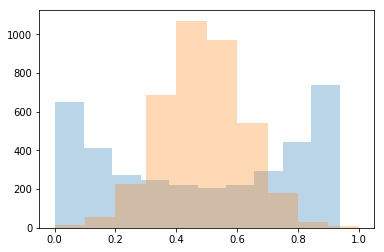

In [85]:
import matplotlib.pyplot as plt
plt.hist(X_new[y_new==0,0],alpha=0.3)
plt.hist(X[y==0,0], alpha=0.3)
plt.show()